\begin{equation*}
 \left\{\begin{array}{ll}
 S' = - 0.1 I(t) S(t),   \\[10pt]
 I' = 0.1 I(t) S(t) - 0.9 I(t), \hskip 3mm t \in [ 0, 3]\\[10pt]
 R' = 0.9 I(t), \\[10pt]
  \ S(0) = 100, \hskip 3mm I(0) = 50, \hskip 3mm R(0) = 0,\\[10pt]
 \end{array} \right.\\[10pt]
 \end{equation*}

# 1. Librerias

In [ ]:
! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=4e77c4de6444c7d133fce18c8e97d8e30919d85e3bf16176a3e8a712240aa72c
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
# Importar librerias
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.autograd as grad
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
import math
#from pyDOE import lhs         #Latin Hypercube Sampling

# 2. SIR

In [ ]:
def SIR(r,t,beta,gamma):

  """
  r : es una matriz que contiene las variables dependientes
  t : vector de las variables independientes

  """

  y1 = r[0]
  y2 = r[1]
  y3 = r[2]

  dy1dt = -beta*y1*y2
  dy2dt = beta*y1*y2 - gamma*y2
  dy3dt = gamma*y2
  return np.array([dy1dt,dy2dt,dy3dt], float)

In [ ]:
from re import T
#N=3000
Nf = 1000 # puntos para evaluar el residuo
print_freq = 2000 # imprimir cada epoca

t0 = 0.
tf = 3
#tf = 2
N = 150
N1 = N+1
beta = 0.1
#beta = 0.05
#beta = 0.2
#gamma = 1
gamma = 0.9
#gamma = 1.2

tt= np.linspace(t0, tf, N1)
S0 = 100
#S0 = 60
I0 = 50
#I0 = 30
#I0 = 20
R0 = 0
#R0 = 20
#R0 = 100
y0 = [S0,I0,R0]
sol = odeint(SIR,y0,tt, args=(beta,gamma))
#sol

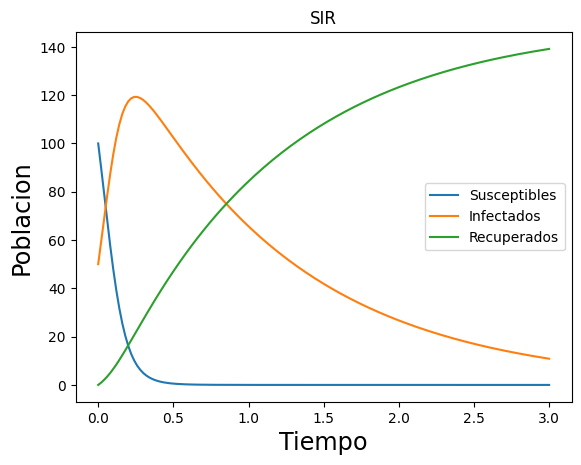

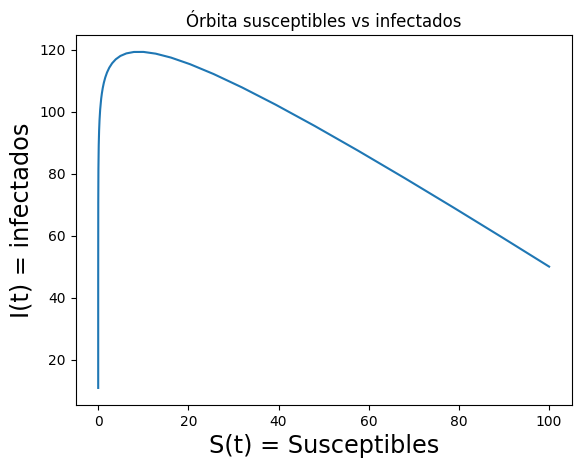

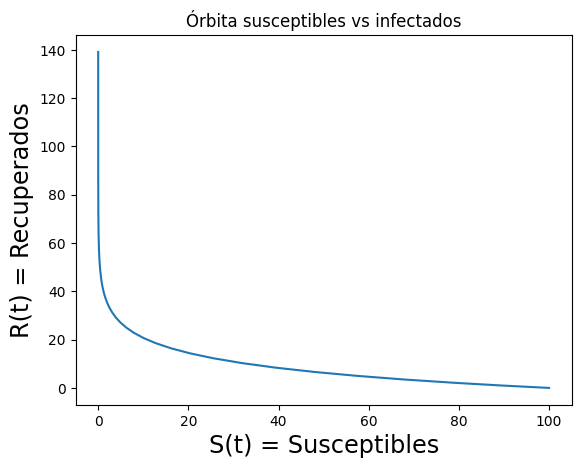

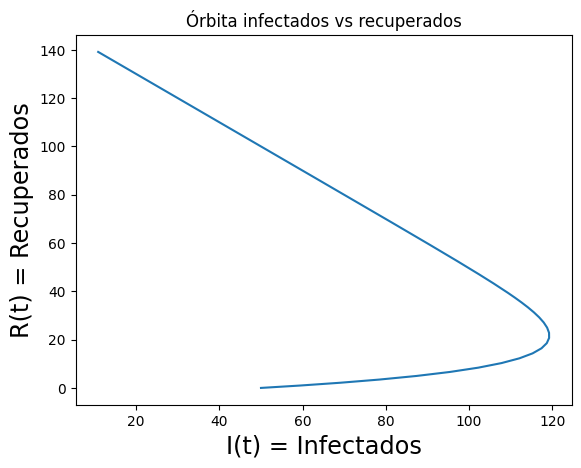

In [ ]:
# representacion de la solucion
fig1 = plt.figure(1)
plt.plot(tt, sol[:,0], label = "Susceptibles")
plt.plot(tt, sol[:,1], label = "Infectados")
plt.plot(tt, sol[:,2], label = "Recuperados")
plt.xlabel("Tiempo")
plt.ylabel("Poblacion")
plt.xlabel("Tiempo",fontsize="xx-large")
plt.ylabel("Poblacion",fontsize="xx-large")
plt.legend()
plt.title("SIR")
plt.show()


# espacio de fases
fig2 = plt.figure(2)
plt.plot(sol[:,0], sol[:,1])
plt.xlabel("S(t) = Susceptibles",fontsize="xx-large")
plt.ylabel("I(t) = infectados",fontsize="xx-large")
plt.title("Órbita susceptibles vs infectados")
plt.show()

fig3 = plt.figure(3)
plt.plot(sol[:,0], sol[:,2])
plt.xlabel("S(t) = Susceptibles",fontsize="xx-large")
plt.ylabel("R(t) = Recuperados",fontsize="xx-large")
plt.title("Órbita susceptibles vs infectados")
plt.show()


fig4 = plt.figure(4)
plt.plot(sol[:,1], sol[:,2])
plt.xlabel("I(t) = Infectados",fontsize="xx-large")
plt.ylabel("R(t) = Recuperados",fontsize="xx-large")
plt.title("Órbita infectados vs recuperados")
plt.show()

# 3. Red Neuronal

In [ ]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [ ]:
class PINN(nn.Module):     # definir la clase (al heredar de nn.Module clase PINN
                           # tiene acceso a muchas utilidades y métodos proporcionados por PyTorch
                           # para el entrenamiento y la evaluación de modelos

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador
                           # llamamos al inicializador de la clase base nn.Module mediante super()
                           # Esto asegura que todas las funcionalidades de nn.Module se inicialicen correctamente
        super(PINN, self).__init__()

        # Definir las capas de la red neuronal (aqui 3 capas lineales: nn.Linear)
        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Una capa lineal significa que salida = Entradas×Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        # Capa 3: Entrada con hidden_size características, salida con 1 característica
        self.fc5 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos (I): Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # Inicialización de pesos (II): Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica o la función logística (sigmoid).
        # Ayuda a mantener una varianza constante a través de las capas
        ## Sale mejor en este ejemplo que sin dicha inicializacion
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.fc5.weight)
        # Inicialización de pesos (III): He Initialization: Similar a la inicialización de Xavier,
        # pero ajustada para su uso con funciones de activación ReLU (Rectified Linear Unit).
        #nn.init.kaiming_normal_(model.fc1.weight)
        #nn.init.kaiming_normal_(model.fc2.weight)
        #nn.init.kaiming_normal_(model.fc3.weight)

        # Inicialización de pesos (IV):  LeCun Initialization:
        # Inicialización propuesta por LeCun para funciones de activación como la tangente hiperbólica
        # nn.init.normal_(layer.weight, mean=0, std=np.sqrt(1 / layer.weight.shape[0]))
        # init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1 / self.fc1.weight.shape[0]))
        # init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1 / self.fc2.weight.shape[0]))
        # init.normal_(self.fc3.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))

        # Inicializacion de las bias
        nn.init.zeros_(self.fc1.bias.data)
        nn.init.zeros_(self.fc2.bias.data)
        nn.init.zeros_(self.fc3.bias.data)
        nn.init.zeros_(self.fc4.bias.data)
        nn.init.zeros_(self.fc5.bias.data)

    def forward(self, x):
       # Define la operación hacia adelante de la red neuronal, i.e cómo se realiza la operación hacia adelante en la red neuronal.
       # Se aplican funciones de activación tangente hiperbólica (torch.tanh) después de cada capa lineal
       # En este caso, el método forward toma la entrada x y la pasa a través de las capas fc1, fc2 y fc3
       # utilizando la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas.
       # La última capa (fc3) no tiene una función de activación
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = torch.tanh(self.fc3(x))
       x = torch.tanh(self.fc4(x))
       x = self.fc5(x)             # No aplicamos función de activación en la última capa fc3

       # Aplicacion a la sigmoide
       #x = torch.sigmoid(self.fc1(x))
       #x = torch.sigmoid(self.fc2(x))
       #x = self.fc3(x)

       return x

In [ ]:
# Función para calcular la derivada
def compute_derivative(model, x):
    g = x.clone()
    g.requires_grad_(True)         # Activar el flag requires_grad para que se realice el seguimiento de gradientes
    y_pred = model(g)# Obtener las predicciones del modelo para las entradas
    s=y_pred[:,0].view(1000,1)
    i=y_pred[:,1].view(1000,1)
    r=y_pred[:,2].view(1000,1)
    s_t = torch.autograd.grad(s, g, grad_outputs=torch.ones_like(s), retain_graph = True, create_graph=True)[0]
    i_t = torch.autograd.grad(i, g, grad_outputs=torch.ones_like(i), retain_graph = True, create_graph=True)[0]
    r_t = torch.autograd.grad(r, g, grad_outputs=torch.ones_like(r), retain_graph = True, create_graph=True)[0]
    return s,i,r,s_t, i_t, r_t

# Función para calcular la condición inicial
def initial_condition(model, x_initial):
    return model(x_initial*torch.ones(1,1))

In [ ]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self,model, s_t, i_t, r_t, s, i, r, t0, y0):
        loss_pde = self.mse_loss(s_t, torch.Tensor(-beta*s*i))
        loss_pde += self.mse_loss(i_t, torch.Tensor(beta*s*i-gamma*i))
        loss_pde += self.mse_loss(r_t, torch.Tensor(gamma*i))
        y_0 = initial_condition(model, t0)
        loss_initial_condition = self.mse_loss(y_0, y0)
        total_loss = loss_pde + loss_initial_condition
        return total_loss

In [ ]:
y0 = torch.Tensor(y0)
y0

tensor([100.,  50.,   0.])

In [ ]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, t0, y0, t_p, num_epochs):

  loss_history = []    # Lista para almacenar la pérdida en cada época
  learning_rates = []  # Lista para almacenar los learning rates en cada iteración/época

  for epoch in range(num_epochs):            # Bucle de entrenamiento
    # Calcular las predicciones de la red y las derivadas
    model.train()

    #h = model(t_data)

    s,i,r,s_t, i_t, r_t = compute_derivative(model, t_p)

    # Calcular la pérdida
    #loss = loss_fn(yh, y_data)
    loss = loss_fn(model,s_t, i_t, r_t, s, i, r, t0,y0)
    # Optimización
    optimizer.zero_grad()  # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()        # Se realiza la retropropagación backward
    optimizer.step()       # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)
    #scheduler.step()
    loss_history.append(loss.item())    # almacentar el error


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)             # almacentar el learning rate
    # Imprimir el progreso
    if (epoch + 1) % print_freq == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates  # Devolver la lista de pérdida al final del entrenamiento y el lerning rate

TypeError: Module.type() missing 1 required positional argument: 'dst_type'

In [ ]:
t_p = torch.linspace(t0,tf,1000).view(-1,1).requires_grad_(True)
#t_p.shape
#Nf= 1000
#t_p = torch.Tensor([t0]) + (torch.Tensor([tf])-torch.Tensor([t0]))*lhs(1,Nf)
#t_p.shape
t_p = t_p.float().to(device)

In [ ]:
t0

0.0

In [ ]:
# Crear una instancia del modelo y del optimizador
# model = PINN(input_size, hidden_size, output_size)
input_size = 1
#hidden_size = 5 , mejor
hidden_size = 32
#hidden_size = 10
output_size = 3
learnig_rate = 0.001
#learning_rate = 0.02
#learnig_rate = 0.02
model = PINN(input_size, hidden_size, output_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)
loss_fn = PINNLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)


# Registrar el tiempo de inicio
start_time = time.time()

#num_epoch = 10000
#num_epoch = 38000
#num_epoch = 30000
num_epoch = 26000
#num_epoch = 25000
#num_epoch = 48000
#num_epoch = 50000
#num_epoch = 60000
# Entrenar el modelo utilizando la función de entrenamiento
loss_history, learning_rates = train(model, optimizer, loss_fn,t0,y0,t_p, num_epoch)

# Registrar el tiempo de finalización
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2000/26000], Total Loss: 1134.614501953125
Epoch [4000/26000], Total Loss: 339.66497802734375
Epoch [6000/26000], Total Loss: 30.31809425354004
Epoch [8000/26000], Total Loss: 0.3401537537574768
Epoch [10000/26000], Total Loss: 0.05158619210124016
Epoch [12000/26000], Total Loss: 0.02238449826836586
Epoch [14000/26000], Total Loss: 0.7479016184806824
Epoch [16000/26000], Total Loss: 0.017785511910915375
Epoch [18000/26000], Total Loss: 0.044814903289079666
Epoch [20000/26000], Total Loss: 0.028928542509675026
Epoch [22000/26000], Total Loss: 0.01095754187554121
Epoch [24000/26000], Total Loss: 0.02722589485347271
Epoch [26000/26000], Total Loss: 0.026310307905077934
 
Tiempo de ejecución: 257.6847929954529 segundos


In [ ]:
t = torch.linspace(t0,tf,130).view(-1,1)

In [ ]:
yh = model(t).detach()
yh
yh.shape

torch.Size([130, 3])

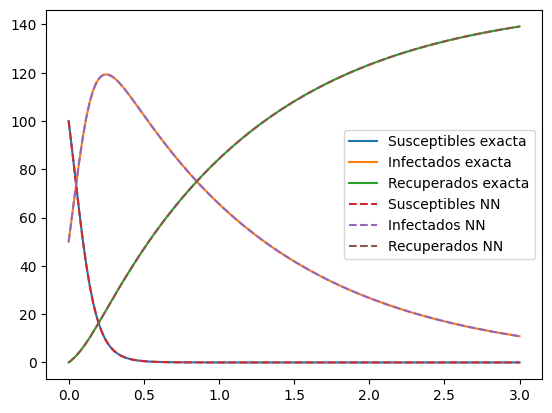

In [ ]:
plt.figure()
plt.plot(tt,sol, label=("Susceptibles exacta", "Infectados exacta", "Recuperados exacta"))
plt.plot(t,yh,linestyle='--', label=("Susceptibles NN", "Infectados NN", "Recuperados NN"))
plt.legend()
plt.show()

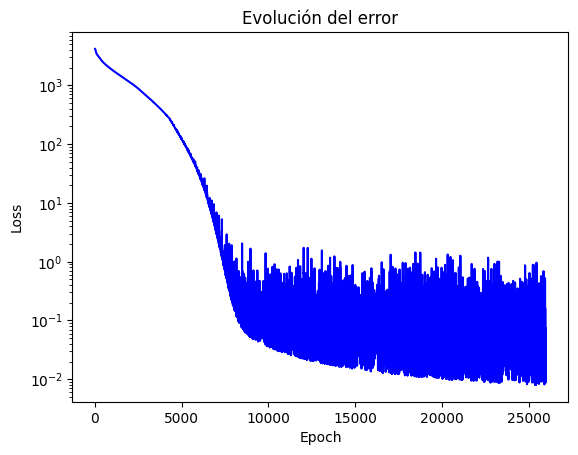

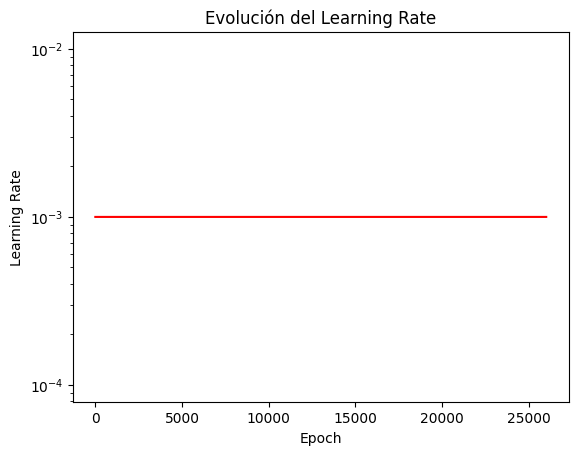

In [ ]:
# Crear una figura con dos subgráficas
plt.figure()
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución del error')
plt.yscale('log')
plt.show()

plt.figure()
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')
plt.yscale('log')


# Ajustar el diseño y mostrar la gráfica

plt.show()